<center><img src="../docs/assets/animated_logo.png" align="center" height="100" width="100">

# [`Optimus-Primal`](https://github.com/astro-informatics/Optimus-Primal) - __Basic 1D FB__ Interactive Tutorial
---

In this interactive tutorial we demonstrate basic usage of `optimusprimal` for a 1-dimensional noisy fitting problem.

How to run a basic 1D unconstrained proximal primal-dual solver. 
We consider the canonical problem $y = x + n$ where $n \sim \mathcal{N}$. 
This inverse problem can be solved via the unconstrained optimisation 

$$
\min_x [ ||(x-y)/\sigma||^2_2 + \lambda ||\Psi^{\dagger} x||_1 ]
$$

where $x \in \mathbb{R}$ is an a priori ground truth 1D signal, $y \in \mathbb{R}$ 
are simulated noisy observations, and $\lambda$ is the regularisation parameter which acts as 
a Lagrangian multiplier, balancing between data-fidelity and prior information. Before we begin, we 
need to import `optimusprimal` and some example specific packages


In [106]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm as normal_dist 

import optimusprimal.forward_backward as forward_backward
import optimusprimal.grad_operators as grad_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.prox_operators as prox_operators

First, we need to define some heuristics for the solver, these include:

      - tol: convergence criteria for the iterations
      - iter: maximum number of iterations
      - update_iter: iterations between logging iteration diagnostics
      - record_iters: whether to record the full diagnostic information



In [107]:
options = {"tol": 1e-5, "iter": 5000, "update_iter": 10, "record_iters": False}

Next, we simulate a standard de-noising setting by contaminating a known
signal $x$ with some Gaussianly distributed noise. Note that for simplicity the
measurement operator here is taken to be the identity operator.



In [108]:
size = 2048                                              # Dimension of the 1D vector
ISNR = 20.0                                              # Input signal to noise ratio
sigma = 10 ** (-ISNR / 20.0)                             # Noise standard deviation
reg_param = 1e-1                                         # Regularisation parameter 

x = normal_dist(0, 0.5).pdf(np.linspace(-2, 2, size))    # Ground truth signal x
y = x + np.random.normal(0, sigma, size)                 # Simulated observations y

For the unconstrained problem with Gaussian noise the data-fidelity constraint
is given by the gradient of the $\ell_2$-norm. Here we set up a gradient operator
corresponding to a gradient of the $\ell_2$-norm.



In [109]:
g = grad_operators.l2_norm(sigma, y, linear_operators.identity())
g.beta = 1. / sigma**2

We regularise this inverse problem by adopting a wavelet sparsity $\ell_1$-norm prior.
To do this we first define what wavelets we wish to use, in this case a
combination of Daubechies family wavelets, and which levels to consider.
Any combination of wavelet families available by the [`PyWavelet`](https://tinyurl.com/5n7wzpmb) package may be
selected.



In [110]:
wav = ["db1", "db4", "db6"]                               # Wavelet dictionaries to combine
levels = 6                                                # Wavelet levels to consider [1-6]
shape = (size,)                                           # Shape of nd-wavelets
psi = linear_operators.dictionary(wav, levels, shape)     # Wavelet linear operator

Next we construct the $\ell_1$-norm proximal operator which we pass the wavelets
($\Psi$) as a dictionary in which to compute the $\ell_1$-norm.



In [111]:
h = prox_operators.l1_norm(np.max(np.abs(psi.dir_op(y))) * reg_param, psi)
h.beta = 1.
f = prox_operators.real_prox()

Finally we run the optimisation...



In [112]:
alpha = 2 / (g.beta + 2)
best_estimate, diagnostics = forward_backward.FB(x_init=y, options=options, g=g, f=f, h=h, alpha=alpha)

2022-03-08 16:47:37,249 - Optimus Primal - INFO - Running Base Forward Backward
2022-03-08 16:47:37,262 - Optimus Primal - INFO - [Forward Backward] 0 out of 5000 iterations, tol = 0.305357
2022-03-08 16:47:37,328 - Optimus Primal - INFO - [Forward Backward] 10 out of 5000 iterations, tol = 0.109128
2022-03-08 16:47:37,381 - Optimus Primal - INFO - [Forward Backward] 20 out of 5000 iterations, tol = 0.073595
2022-03-08 16:47:37,448 - Optimus Primal - INFO - [Forward Backward] 30 out of 5000 iterations, tol = 0.049439
2022-03-08 16:47:37,519 - Optimus Primal - INFO - [Forward Backward] 40 out of 5000 iterations, tol = 0.033118
2022-03-08 16:47:37,703 - Optimus Primal - INFO - [Forward Backward] 50 out of 5000 iterations, tol = 0.022142
2022-03-08 16:47:37,824 - Optimus Primal - INFO - [Forward Backward] 60 out of 5000 iterations, tol = 0.014785
2022-03-08 16:47:37,939 - Optimus Primal - INFO - [Forward Backward] 70 out of 5000 iterations, tol = 0.009865
2022-03-08 16:47:38,039 - Optimus

...and plot the results!



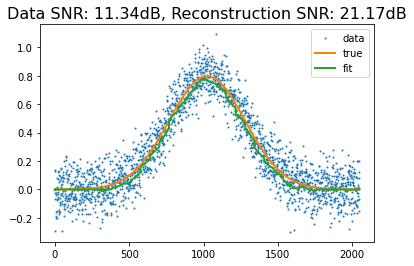

In [113]:
def eval_snr(x, x_est):
    if np.array_equal(x, x_est):
        return 0
    num = np.sqrt(np.sum(np.abs(x) ** 2))
    den = np.sqrt(np.sum(np.abs(x - x_est) ** 2))
    return round(20*np.log10(num/den), 2)

SNR_est = eval_snr(x, best_estimate)
SNR_data = eval_snr(x, y)

plt.plot(np.real(y), "o", markersize=1)
plt.plot(np.real(x), linewidth=2)
plt.plot(np.real(best_estimate), linewidth=2)
plt.legend(["data", "true", "fit"])

plt.title("Data SNR: {}dB, Reconstruction SNR: {}dB".format(SNR_data, SNR_est), fontsize=16)
plt.show()